# **RESTAURANTES MICHELIN EN EL MUNDO**

## **Importamos** las librerías y el CSV

In [8]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import contextily as ctx
import matplotlib.pyplot as plt

In [3]:
url = "C:/Users/34666/Documents/MASTER EN IA/THE BRIDGE/REPO_CLASE/REPO_PRACTICE/EDA/RESTAURANTS/data/michelin_my_maps.csv"

df = pd.read_csv(url)
df.head(2)


,Name,Address,Location,Price,Cuisine,Longitude,Latitude,PhoneNumber,Url,WebsiteUrl,Award,GreenStar,FacilitiesAndServices,Description
0,ES:SENZ,"Mietenkamer Straße 65, Grassau, 83224, Germany","Grassau, Germany",€€€€,"Creative, Modern Cuisine",12.465618,47.785630,4.986414e+11,https://guide.michelin.com/en/bayern/grassau/r...,https://www.das-achental.com/,3 Stars,0,"Air conditioning,Car park,Interesting wine list","Here in the restaurant of Das Achental hotel, ..."
1,Tohru in der Schreiberei,"Burgstraße 5, Munich, 80331, Germany","Munich, Germany",€€€€,"Modern Cuisine, Japanese Contemporary",11.577475,48.137597,4.989215e+11,https://guide.michelin.com/en/bayern/mnchen/re...,https://schreiberei-muc.de/,3 Stars,0,"Interesting wine list,Notable sake list",It is absolutely worth climbing the 23 steps o...


---
## **Limpiamos** el DataFrame.

In [4]:
# Eliminar las columnas no deseadas
columns_to_drop = [
    "PhoneNumber", "Cuisine", "Location", "Url", "WebsiteUrl", 
    "FacilitiesAndServices", "Description", "Price", "Address", "GreenStar"
]
df_cleaned = df.drop(columns=columns_to_drop)

# Crear una geometría con latitud y longitud
geometry = [Point(xy) for xy in zip(df_cleaned["Longitude"], df_cleaned["Latitude"])]

# Crear el GeoDataFrame en CRS WGS84
gdf = gpd.GeoDataFrame(df_cleaned, geometry=geometry, crs="EPSG:4326")

# Convertir a Web Mercator (EPSG:3857)
gdf_web_mercator = gdf.to_crs(epsg=3857)

# Eliminar columnas originales de lat/lon
gdf_web_mercator = gdf_web_mercator.drop(columns=["Latitude", "Longitude"])
gdf_web_mercator

,Name,Award,geometry
0,ES:SENZ,3 Stars,POINT (1387666.204 6071265.148)
1,Tohru in der Schreiberei,3 Stars,POINT (1288798.622 6129776.677)
2,Schwarzwaldstube,3 Stars,POINT (930439.507 6196647.129)
3,Victor's Fine Dining by christian bau,3 Stars,POINT (711021.065 6366161.817)
4,Aqua,3 Stars,POINT (1201134.912 6878771.779)
...,...,...,...
18152,Gosari Express,Selected Restaurants,POINT (14139802.834 4518332.804)
18153,L'Orangerie,Selected Restaurants,POINT (202487.371 6214994.036)
18154,Zhou Men,Bib Gourmand,POINT (12605187.355 2648145.557)
18155,Leowe,Selected Restaurants,POINT (12615767.872 2648058.75)


---
## **Pintamos** los gráficos

#### **Pintamos** Mapa mundi de los restaurantes de estrellas Michelín

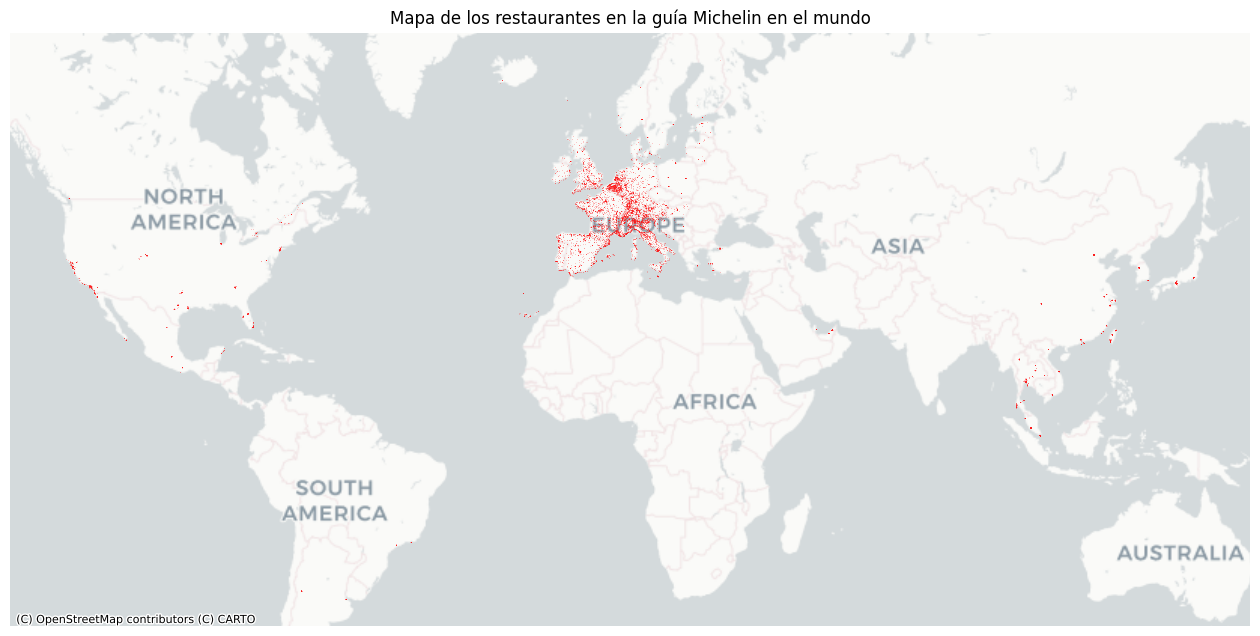

In [13]:
# 4. Crear el gráfico
ax = gdf_web_mercator.plot(
    figsize=(16, 9),
    alpha=0.6,
    color="#ff1b1b",
    markersize=0.2,
    edgecolor="#ff1b1b",
    linewidth=0.03
)

ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

plt.axis('off')
plt.title("Mapa de los restaurantes en la guía Michelin en el mundo")

# Guardar imagen del gráfico.
plt.savefig("img/export_by_vsc/Michelin_mapa_restaurantes.png", dpi=150, bbox_inches='tight')

plt.show()

In [15]:
gdf_web_mercator["Award"].value_counts()

Award
Selected Restaurants    11036
Bib Gourmand             3370
1 Star                   3087
2 Stars                   507
3 Stars                   157
Name: count, dtype: int64

#### **Pintamos** diagrama de barras

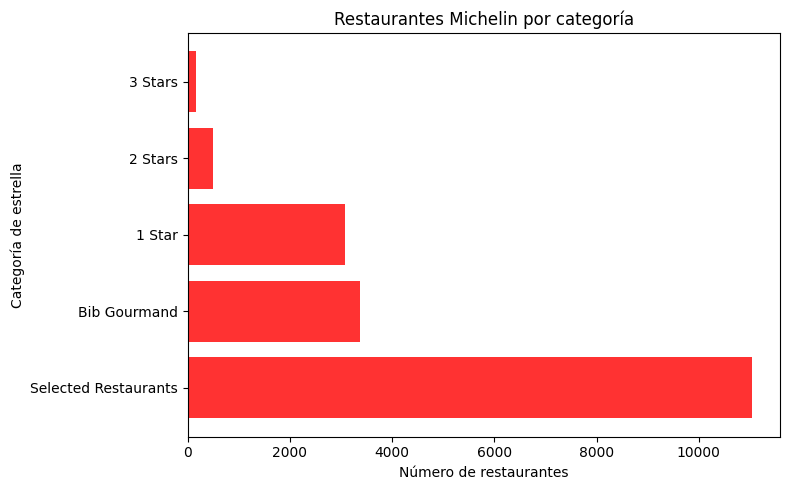

In [21]:
award_counts = gdf_web_mercator["Award"].value_counts().reset_index()
award_counts.columns = ["Award", "Count"]
award_counts = award_counts.sort_values(by="Count", ascending=True)
# Crear gráfico de barras horizontal
plt.figure(figsize=(8, 5))
plt.barh(award_counts["Award"], award_counts["Count"], color="#ff1b1b", alpha=0.9)
plt.xlabel("Número de restaurantes")
plt.ylabel("Categoría de estrella")
plt.title("Restaurantes Michelin por categoría")
plt.gca().invert_yaxis()  # Opcional: poner la categoría más alta arriba
plt.tight_layout()

# Guardar imagen del gráfico.
plt.savefig("img/export_by_vsc/Restaurantes_Michelin_por categoria.png", dpi=150, bbox_inches='tight')

plt.show()

#### **Limpiamos** para sacar restaurantes más prestigiosos

In [47]:
# Filtro por '3 Stars'
gdf_3stars = gdf_web_mercator[gdf_web_mercator["Award"] == "3 Stars"]

# Definir límites para España en EPSG:3857 aproximadamente
xmin_es, xmax_es = (-1200000, 500000)   # Longitud aproximada
ymin_es, ymax_es = (4000000, 5400000)   # Latitud aproximada

gdf_3stars_spain = gdf_3stars.cx[xmin_es:xmax_es, ymin_es:ymax_es]

counts = {
    "Mundo": len(gdf_3stars),
    "España": len(gdf_3stars_spain)
}


# # Limitar aún más a Madrid (zona centro)
# xmin_mad, xmax_mad = (-400000, -250000)
# ymin_mad, ymax_mad = (4470000, 4220000)

gdf_3stars_madrid = gdf_3stars.cx[xmin_mad:xmax_mad, ymin_mad:ymax_mad]

# Contar los restaurantes por región
# counts = {
#     "Mundo": len(gdf_3stars),
#     "España": len(gdf_3stars_spain),
#     "Madrid": len(gdf_3stars_madrid)
# }
gdf_3stars_spain = gdf_3stars_spain[gdf_3stars_spain["Name"] != "Auberge du Vieux Puits"]
gdf_3stars_spain

,Name,Award,geometry
95,Azurmendi,3 Stars,POINT (-313313.16 5351729.963)
96,Aponiente,3 Stars,POINT (-692011.325 4383959.018)
97,DiverXO,3 Stars,POINT (-410287.075 4932765.135)
98,Noor,3 Stars,POINT (-529716.825 4563889.573)
99,Cenador de Amós,3 Stars,POINT (-411751.238 5374969.034)
100,Quique Dacosta,3 Stars,POINT (9486.747 4700749.603)
101,Atrio,3 Stars,POINT (-709254.948 4789655.662)
102,Casa Marcial,3 Stars,POINT (-578099.437 5375876.246)
103,El Celler de Can Roca,3 Stars,POINT (312577.004 5159961.281)
104,Akelaŕe,3 Stars,POINT (-227496.43 5358924.451)


#### **Pintamos** la comparativa de los restaurantes de 3 estrellas Michelin en España VS Mundo

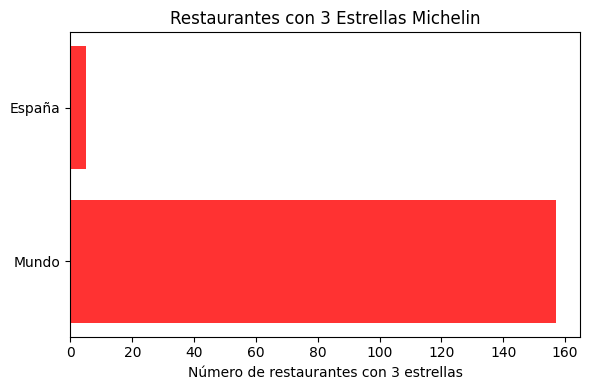

In [26]:
# Crear gráfico
plt.figure(figsize=(6, 4))
plt.barh(list(counts.keys()), list(counts.values()), color="#ff1b1b", alpha=0.9)
plt.xlabel("Número de restaurantes con 3 estrellas")
plt.title("Restaurantes con 3 Estrellas Michelin")
plt.tight_layout()

# Guardar imagen del gráfico.
plt.savefig("img/export_by_vsc/Restaurantes_3estrellas_espana.png", dpi=150, bbox_inches='tight')

plt.show()

#### **Pintamos** el mapa español de la ubicación de estos restaurantes 3*.

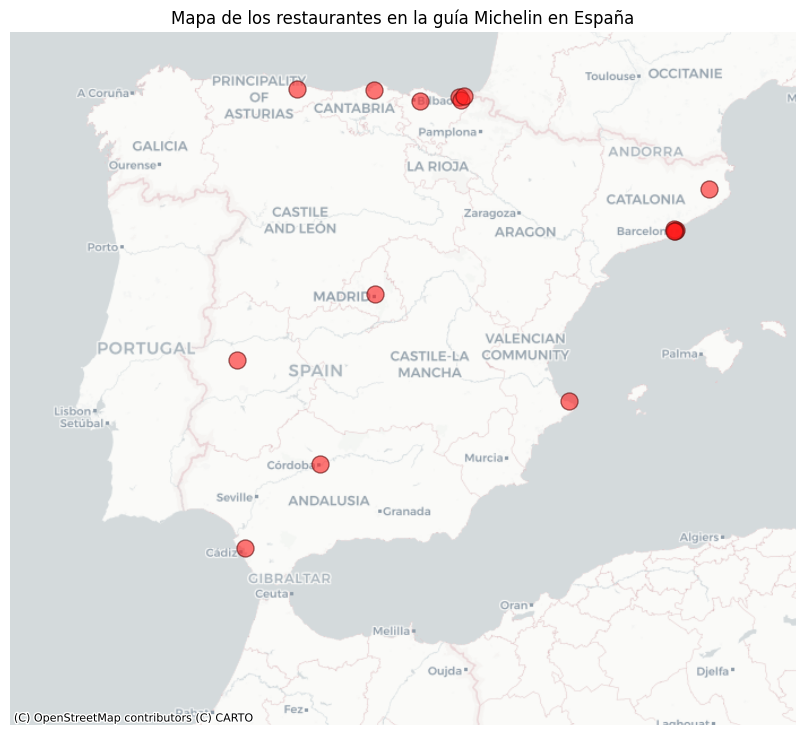

In [48]:
# 4. Crear el gráfico
ax = gdf_3stars_spain.plot(
    figsize=(16, 9),
    alpha=0.6,
    color="#ff1b1b",
    markersize=150,
    edgecolor="#5f0c0c",
    linewidth=1
)

# Coordenadas para ver toda la ciudad de Madrid con un poco más de margen
ax.set_xlim([-1200000, 500000])
ax.set_ylim([4000000, 5500000])

ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

plt.axis('off')
plt.title("Mapa de los restaurantes en la guía Michelin en España")

# Guardar imagen del gráfico.
plt.savefig("img/export_by_vsc/Michelin_mapa_eapana_restaurantes.png", dpi=150, bbox_inches='tight')

plt.show()